### Importing Necessary Libraries

In [100]:
# Core Python Libraries
import os  # Operating system interactions, such as reading and writing files.
import shutil  # High-level file operations like copying and moving files.
import random  # Random number generation for various tasks.
import textwrap  # Formatting text into paragraphs of a specified width.
import warnings  # Warning control context manager.
import zipfile  # Work with ZIP archives.
import platform  # Access to underlying platform’s identifying data.
import itertools  # Functions creating iterators for efficient looping.
from dataclasses import dataclass  # Class decorator for adding special methods to classes.

# PyTorch-related Libraries (Deep Learning)
import torch  # Core PyTorch library for tensor computations.
import torch.nn as nn  # Neural network module for defining layers and architectures.
import torch.optim as optim  # Optimizer module for training models (SGD, Adam, etc.).
from torch.utils.data import Dataset, DataLoader, Subset, random_split  # Dataset and DataLoader for managing and batching data.
import torchvision # PyTorch's computer vision library.
from torchvision import datasets, transforms  # Datasets and transformations for image processing.
import torchvision.datasets as datasets  # Datasets for computer vision tasks.
import torchvision.transforms as transforms  # Transformations for image preprocessing.
from torchvision.utils import make_grid  # Make grid for displaying images.
import torchvision.models as models  # Pretrained models for transfer learning.
import torchvision.transforms.functional as TF  # Functional transformations for image preprocessing.
from torchsummary import summary # PyTorch model summary for Keras-like model summary.
from torchviz import make_dot  # PyTorch model visualization.
from torchvision.ops import sigmoid_focal_loss  # Focal loss for handling class imbalance in object detection.
from torchmetrics import MeanMetric  # Intersection over Union (IoU) metric for object detection.
from torchmetrics.classification import MultilabelF1Score, MultilabelRecall, MultilabelPrecision, MultilabelAccuracy  # Multilabel classification metrics.

import lightning.pytorch as pl
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

# Geospatial Data Processing Libraries
import rasterio  # Library for reading and writing geospatial raster data.
from rasterio.warp import calculate_default_transform, reproject  # Reprojection and transformation functions.
from rasterio.enums import Resampling  # Resampling methods used for resizing raster data.
from rasterio.plot import show  # Visualization of raster data.

# Data Manipulation and Analysis Libraries
import pandas as pd  # Data analysis and manipulation library for DataFrames and CSVs.
import numpy as np  # Numpy for array operations and numerical computations.
from sklearn.metrics import confusion_matrix, accuracy_score  # Evaluation metrics for classification models.

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting library for creating static and interactive visualizations.
import seaborn as sns  # High-level interface for drawing attractive statistical graphics.

# Utilities
from tqdm import tqdm  # Progress bar for loops and processes.
from PIL import Image  # Image handling, opening, manipulating, and saving.
import ast  # Abstract Syntax Trees for parsing Python code.
import requests  # HTTP library for sending requests.
import zstandard as zstd  # Zstandard compression for fast compression and decompression.
from collections import Counter # Counter for counting hashable objects.
import certifi  # Certificates for verifying HTTPS requests.
import ssl  # Secure Sockets Layer for secure connections.
import urllib.request  # URL handling for requests.
import kaggle # Kaggle API for downloading datasets.
import zipfile # Work with ZIP archives.

In [101]:
pl.seed_everything(42)  # Set seed for reproducibility.
main_path = 'D:\Datasets'
dataset_path = os.path.join(main_path, 'eurosat')

Seed set to 42


In [102]:
@dataclass
class Config:
    num_epochs = 10  # Number of epochs for training.
    batch_size = 64  # Batch size for training.
    learning_rate = 1e-3  # Learning rate for training.
    input_size = 224  # Input size for the model.
    resize = 256  # Resize size for the images.
    num_classes = 10  # Number of classes in the dataset.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Device for training.
    num_workers = 4  # Number of workers for the DataLoader.
    optimizer = optim.Adam # Optimizer for training.
    optimizer_name = 'Adam'  # Optimizer name for training.
    channels = 3 # Number of channels in the images.

    image_mean = [0.485, 0.456, 0.406]  # Image mean for normalization.
    image_std = [0.229, 0.224, 0.225]  # Image standard deviation for normalization.

    model_name = 'resnet18'  # Model name for training.
    image_size = (224,224)  # Image size for the model.

    train_path = os.path.join(dataset_path, 'train.csv')
    val_path = os.path.join(dataset_path, 'validation.csv')
    test_path = os.path.join(dataset_path, 'test.csv')

    dataset_path = os.path.join(dataset_path, '2750')


### Creating a Custom Dataset Class
This is a custom PyTorch Dataset class designed to load images and labels (if available) for each set. The PyTorch "Dataset" class is essential for efficient and organized data handling in machine learning tasks. It provides a standardized interface to load and preprocess data samples from various sources. Encapsulating the dataset into a single object simplifies data management and enables seamless integration with other PyTorch components like data loaders and models. 

In [103]:
class EuroSATDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])  # Path from Filename column
        image = Image.open(img_name).convert('RGB')  # Convert to RGB if necessary
        label = self.data_frame.iloc[idx, 2]  # Label column

        if self.transform:
            image = self.transform(image)

        return image, label

### Custom LightningDataModule class to Load dataset
This class inherits from Lightning’s LightningDataModule class and encapsulates the following steps:

1) Download the dataset.
2) Create train and validation splits.
3) Create a Dataset class object for each split with appropriate transformations.
4) Create DataLoader objects for each split.

In [104]:
class EuroSATDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=16, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([Config.image_mean], [Config.image_std])
        ])

        self.valid_tfms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([Config.image_mean], [Config.image_std])
        ])
        
        self.test_tfms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([Config.image_mean], [Config.image_std])
        ])

    def prepare_data(self):
        if not os.path.exists(Config.dataset_path):
            kaggle.api.dataset_download_files('apollo2506/eurosat-dataset', path=Config.dataset_path, unzip=True)
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = EuroSATDataset(
                csv_file=Config.train_path,
                root_dir=self.data_dir,
                transform=self.train_tfms
            )
            self.val_dataset = EuroSATDataset(
                csv_file=Config.val_path,
                root_dir=self.data_dir,
                transform=self.valid_tfms
            )

        if stage == 'test' or stage is None:
            self.test_dataset = EuroSATDataset(
                csv_file=Config.test_path,
                root_dir=self.data_dir,
                transform=self.test_tfms
            )

    def train_dataloader(self):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
        return train_loader
    
    def val_dataloader(self):
        val_loader =DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        return val_loader

    def test_dataloader(self):
        test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        return test_loader

In [105]:
%%time

dm = EuroSATDataModule(
    data_dir=Config.dataset_path,
    batch_size=32, 
    num_workers=0
)

# Donwload dataset.
dm.prepare_data()

# Split datset into training, validation set.
dm.setup()

CPU times: total: 0 ns
Wall time: 27.5 ms


In [106]:
def get_model(model_name: str, num_classes: int, freeze_backbone: bool= True):
    model = getattr(torchvision.models, model_name)(weights="DEFAULT")
    
    if freeze_backbone:
        # Set all layer to be non-trainable
        for param in model.parameters():
            param.requires_grad = False
        
    model_childrens = [name for name, _ in model.named_children()]

    try:
        final_layer_in_features = getattr(model, f"{model_childrens[-1]}")[-1].in_features
    except Exception as e:
        final_layer_in_features = getattr(model, f"{model_childrens[-1]}").in_features

    new_output_layer = nn.Linear(
        in_features=final_layer_in_features, 
        out_features=num_classes
    )
    
    try:
        getattr(model, f"{model_childrens[-1]}")[-1] = new_output_layer
    except:
        setattr(model, model_childrens[-1], new_output_layer)
    
    return model

In [107]:
# Create the model
model = get_model(
    model_name=Config.model_name, 
    num_classes=Config.num_classes,
    freeze_backbone=False,
)

# Print the model name
print(f"Model Name: {Config.model_name}")

# Print the model summary
summary(
    model, 
    input_size=(Config.channels, *Config.image_size), 
    device="cpu"
)

# Create a sample input tensor
sample_input = torch.randn(1, Config.channels, *Config.image_size)

# Pass the sample input through the model to create the graph
model_graph = make_dot(model(sample_input), params=dict(model.named_parameters()))

# Save the graph to a file
output_directory = r'C:\Users\isaac\FYPCodeLatest\models'
os.makedirs(output_directory, exist_ok=True)
model_graph.format = 'png'
model_graph.directory = output_directory
model_graph.filename = Config.model_name
model_graph.view()

Model Name: resnet18
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-

'C:\\Users\\isaac\\FYPCodeLatest\\models\\resnet18.png'

### Custom Lightning Module Class for the Model
Create a class that contains the following main methods: 

In [108]:
class EuroSATModel(pl.LightningModule):
    def __init__(
            self, 
            model_name: str,
            num_classes=10,
            freeze_backbone: bool = False,
            learning_rate: float = 1e-3,
            optimizer_name: str = 'Adam',
            weight_decay: float = 0.0,
            use_scheduler: bool = False,
            f1_metric_threshold: float = 0.5
    ):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()

        # Loading model using the function defined above.
        self.model = get_model(
            model_name=self.hparams.model_name,
            num_classes=self.hparams.num_classes,
            freeze_backbone=self.hparams.freeze_backbone,
        )

        # Intialize loss class.
        self.loss_fn = nn.BCEWithLogitsLoss()

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_f1   = MultilabelF1Score(num_labels=self.hparams.num_classes, 
                                                 average="macro", threshold=self.hparams.f1_metric_threshold)
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_f1   = MultilabelF1Score(num_labels=self.hparams.num_classes, 
                                                 average="macro", threshold=self.hparams.f1_metric_threshold)
        
        #self.model = models.resnet50(pretrained=True)
        #self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)
        #self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-3)
        return optimizer
    
    def on_train_epoch_end(self):
        # Computing and logging the training mean loss & mean f1.
        self.log("train/loss", self.mean_train_loss, prog_bar=True)
        self.log("train/f1",   self.mean_train_f1,   prog_bar=True)
        self.log("step", self.current_epoch)

    def on_validation_epoch_end(self):
        # Computing and logging the validation mean loss & mean f1.
        self.log("valid/loss", self.mean_valid_loss, prog_bar=True)
        self.log("valid/f1",   self.mean_valid_f1,   prog_bar=True)
        self.log("step", self.current_epoch)

In [113]:
pl.seed_everything(42)  # Set seed for reproducibility.

model = EuroSATModel(num_classes=Config.num_classes, model_name=Config.model_name)

data_module = EuroSATDataModule(
    data_dir=Config.dataset_path,
    batch_size=Config.batch_size,
    num_workers=Config.num_workers
)

model_checkpoint = ModelCheckpoint(
    monitor="valid/f1",
    mode="max",
    filename="ckpt_{epoch:03d}-vloss_{valid/loss:.4f}_vf1_{valid/f1:.4f}", 
    auto_insert_metric_name=False,
)

lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")

Seed set to 42


In [ ]:
trainer = pl.Trainer(
    accelerator="auto", # Auto select the best hardware accelerator available
    devices="auto", # Auto select available devices for the accelerator (For eg. mutiple GPUs)
    strategy="auto", # Auto select the distributed training strategy.
    max_epochs=Config.num_epochs, # Maximum number of epoch to train for.
    deterministic=True, # For deteministic and reproducible training.
    enable_model_summary=False, # Disable printing of model summary as we are using torchinfo.
    callbacks=[model_checkpoint, lr_rate_monitor],  # Declaring callbacks to use.
    precision="16", # Using Mixed Precision training.
    logger=True, # Auto generate TensorBoard logs.
)
# Start training
trainer.fit(model, data_module)

C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\lightning\fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\isaac\anaconda3\envs\Fyp311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


C:\Users\isaac\AppData\Local\Temp\ipykernel_25628\727998865.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Count', data=category_counts, palette='viridis')


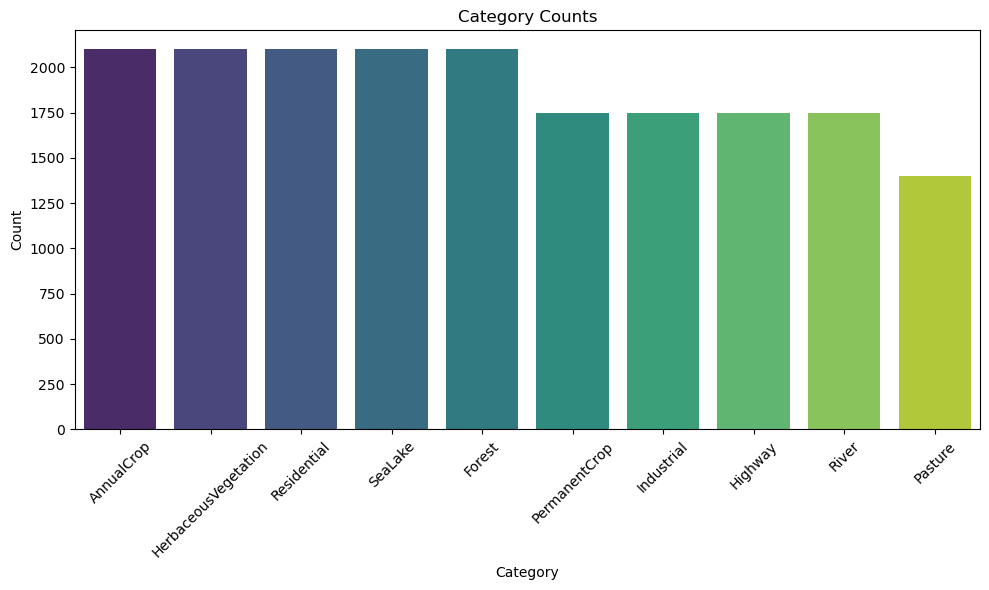

In [112]:
data_df = pd.read_csv(Config.train_path)

# Calculate category counts
category_counts = data_df['ClassName'].value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Plot the category counts as a bar graph using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=category_counts, palette='viridis')
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()